In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision import transforms


def get_transforms(std=0.5, mean=0.5):
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((mean,), (std,))
    ])
    
def cut_data(data, first_proportion=0.8):
    first_size = int(len(data) * first_proportion)
    second_size = len(data) - first_size
    first_data, second_data = torch.utils.data.random_split(data, [first_size, second_size])
    return first_data, second_data

def get_data_MNIST(std=0.5, mean=0.5, train_size=0.8):
    train_data = datasets.FashionMNIST(root='data', train=True, transform=get_transforms(std, mean), download=True)
    test_data = datasets.FashionMNIST(root='data', train=False, transform=get_transforms(std, mean), download=True)
    train_data, val_data = cut_data(train_data, train_size)
    return train_data, val_data, test_data

def get_data_CIFAR10(std=0.5, mean=0.5, train_size=0.8):
    train_data = datasets.CIFAR10(root='data', train=True, transform=get_transforms(std, mean), download=True)
    test_data = datasets.CIFAR10(root='data', train=False, transform=get_transforms(std, mean), download=True)
    train_data, val_data = cut_data(train_data, train_size)
    return train_data, val_data, test_data

def inspect(data):
    print(f"Data type: {type(data)}")
    print(f"Data length: {len(data)}")
    print(f"Data shape: {data[0][0].shape}")
    
def check_data(train_data, val_data, test_data):
    inspect(train_data)
    inspect(val_data)
    inspect(test_data)
    # Total de datos
    print(f"Total data: {len(train_data) + len(val_data) + len(test_data)}\n")

In [2]:
train_mnist, val_mnist, test_mnist = get_data_MNIST()
check_data(train_mnist, val_mnist, test_mnist)
train_cifar10, val_cifar10, test_cifar10 = get_data_CIFAR10()
check_data(train_cifar10, val_cifar10, test_cifar10)

100.0%


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw

Data type: <class 'torch.utils.data.dataset.Subset'>
Data length: 48000
Data shape: torch.Size([1, 28, 28])
Data type: <class 'torch.utils.data.dataset.Subset'>
Data length: 12000
Data shape: torch.Size([1, 28, 28])
Data type: <class 'torchvision.datasets.mnist.FashionMNIST'>
Data length: 10000
Data shape: torch.Size([1, 28, 28])
Total data: 70000

Files already downloaded and verified
Files already downloaded and verified
Data type: <class 'torch.utils.data.dataset.Subset'>
Data length: 40000
Data shape: torch.Size([3, 32, 32])
Data type: <class 'torch.utils.data.dataset.Subset'>
Data length: 10000
Data shape: torch.Size([3, 32, 32])
Data type: <class 'torchvision.datasets.cifar.CIFAR10'>
Data length: 10000
Data shape: torch.Size([3, 32, 32])
Total data: 60000



In [3]:
# Plotear una imagen de ejemplo
def plot_image(data, index):
    image, label = data[index]
    fig = plt.figure(figsize=(5, 5))
    # Check rgb or grayscale
    if image.shape[0] == 1:
        image = image[0]
        plt.imshow(image, cmap='gray')
    else:
        image = image.permute(1, 2, 0)
        plt.imshow(image)
    plt.title(f"Label: {label}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


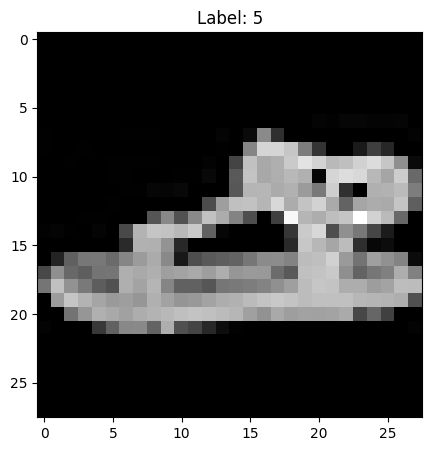

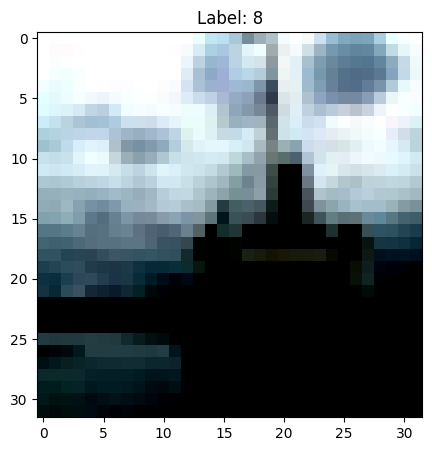

In [6]:
plot_image(train_mnist, 10)
plot_image(train_cifar10, 10) 

In [7]:
# Creamos una capa de convolución

class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding='same'):
        super(ConvLayer, self).__init__()
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        return self.relu(self.conv(x))
    
# Max Pooling + Batch Normalization + Dropout (opcional)
class MaxPoolBN(torch.nn.Module): 
    def __init__(self, in_channels, kernel_size = 2, stride=2, padding=0, dropout=0.1):
        super(MaxPoolBN, self).__init__()
        self.max_pool = torch.nn.MaxPool2d(kernel_size, stride, padding)
        self.bn = torch.nn.BatchNorm2d(in_channels)
        self.dropout = torch.nn.Dropout(dropout)
        
    def forward(self, x):
        return self.dropout(self.bn(self.max_pool(x)))
    
# Capa densa + dropout (opcional)
class Dense(torch.nn.Module):
    def __init__(self, in_features, out_features, dropout=0.1):
        super(Dense, self).__init__()
        self.linear = torch.nn.Linear(in_features, out_features)
        self.dropout = torch.nn.Dropout(dropout)
        
    def forward(self, x):
        return self.dropout(self.linear(x))
    
# structure = [N, L1, k1, ..., Ln, kn], con L la cantidad de capas y k el kernel size
class ConvNet(torch.nn.Module):
    def __init__(self,in_channels, structure, size, classes):
        super(ConvNet, self).__init__()
        self.size = size
        self.structure = structure
        self.L = [structure[i] for i in range(len(structure)) if i % 2 == 1]
        self.k = [structure[i] for i in range(len(structure)) if i % 2 == 0 and i != 0]
        self.layers = torch.nn.ModuleList()
        for i in range(len(self.L)):
            if i == 0:
                self.layers.append(ConvLayer(in_channels, self.L[i], self.k[i]))
                self.layers.append(torch.nn.Dropout(0.1))
            else:
                self.layers.append(ConvLayer(self.L[i-1], self.L[i], self.k[i]))
                self.layers.append(torch.nn.Dropout(0.1))
                
            # Max pooling en cantidad par de capas 
            if i % 2 == 1:
                self.layers.append(MaxPoolBN(self.L[i], 2))
                self.size = self.size // 2
                
        # Caso impares
        if len(self.L) % 2 == 1:
            self.layers.append(MaxPoolBN(self.L[-1], 2))
            self.size = self.size // 2
            
        # Cabeza clasificadora
        self.layers.append(torch.nn.Flatten())
        self.layers.append(Dense(self.L[-1] * self.size * self.size, 128))
        self.layers.append(torch.nn.Dropout(0.5))
        self.layers.append(Dense(128, classes))
        if self.size == 0:
            self.size=1       
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
# Profundidad de CIFAR10 (32/2^4 = 2 -> 4x2 capas convolucionales maximo) depth in [2,8]
# E:32 --c1--> 32 --c2--> 32 --MP-->
# 16 --c3--> 16 --c4--> 16 --MP-->
# 8 --c5--> 8 --c6--> 8 --MP-->
# 4 --c7--> 4 --c8--> 4 --MP--> 2 

In [8]:
# Probar con un batch de entrada 1 x 1 x 28 x 28
# Cargamos el dataset de CIFAR10
train_data, val_data, test_data = get_data_CIFAR10()

Files already downloaded and verified
Files already downloaded and verified


In [9]:
# Creamos el modelo
# L = [64, 64, 128, 128, 128, 128, 64, 64]
# k = [ 3,  3,   3,   3,   3,   3,  3,  3]
# structure = [item for sublist in [[L[i], k[i]] for i in range(len(L)) ] for item in sublist]
# structure = [len(structure)//2] + structure
structure = [3, 16, 3, 32, 5, 64, 3]

# Obtener un ejemplo de entrada
x, y = train_data[0]
x = x.unsqueeze(0)
print(f"Input shape: {x.shape}")

# Creamos el modelo
model = ConvNet(3, structure, size=32, classes=10)
print(model)

Input shape: torch.Size([1, 3, 32, 32])
ConvNet(
  (layers): ModuleList(
    (0): ConvLayer(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (relu): ReLU()
    )
    (1): Dropout(p=0.1, inplace=False)
    (2): ConvLayer(
      (conv): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
      (relu): ReLU()
    )
    (3): Dropout(p=0.1, inplace=False)
    (4): MaxPoolBN(
      (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (5): ConvLayer(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (relu): ReLU()
    )
    (6): Dropout(p=0.1, inplace=False)
    (7): MaxPoolBN(
      (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [10]:
structure

[3, 16, 3, 32, 5, 64, 3]

In [11]:
# Probamos el modelo
y_pred = model(x)

In [89]:
def run_epoch(model, data_loader, criterion, optimizer, device, train=True):
    if train:
        model.train()
    else:
        model.eval()
    
    loss_total = 0
    acc_total = 0
    for x, y in data_loader:
        # Enviamos los datos al dispositivo
        x = x.to(device)
        y = y.to(device)
        # Forward
        with torch.set_grad_enabled(train):
            y_pred = model(x)
            loss = criterion(y_pred, y)
        # Backward
        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # Acumulamos los resultados
        loss_total += loss.item() * x.size(0)
        acc_total += (y_pred.argmax(1) == y).sum().item()
    # Promediamos los resultados
    loss_total /= len(data_loader.dataset)
    acc_total /= len(data_loader.dataset)
    return loss_total, acc_total

def train_epoch(model, train_loader, val_loader, criterion, optimizer, device):
    train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer, device, train=True)
    val_loss, val_acc = run_epoch(model, val_loader, criterion, optimizer, device, train=False)
    return train_loss, train_acc, val_loss, val_acc

# Entrenar un modelo
def train(model, train_data, val_data, epochs=100, batch_size=256, lr=0.001, device='cpu', folder='models', verbose=False):
    # Definimos el optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # Definimos la función de costo
    criterion = torch.nn.CrossEntropyLoss()
    # Enviamos el modelo al dispositivo
    model.to(device)
    # Definimos los dataloaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
    # Definimos las listas para guardar los resultados
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    # Early stopping
    epochs_without_improvement = 0
    # Entrenamos
    for epoch in range(epochs):
        # Entrenamos un epoch
        train_loss, train_acc, val_loss, val_acc = train_epoch(model, train_loader, val_loader, criterion, optimizer, device)
        # Guardamos los resultados
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        # Si mejora el resultado, guardamos el modelo
        best_val_loss = np.min(val_losses)
        if val_loss > best_val_loss:
            torch.save(model.state_dict(), f"{folder}/model.pth")
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        # Si no mejora el resultado durante 5 epochs, detenemos el entrenamiento
        if epochs_without_improvement == 5:
            print(f"Training stopped at epoch {epoch+1}")
            break
        # Imprimimos los resultados
        if verbose:
            print(f"Epoch {epoch+1}/{epochs}:")
            print(f"Train loss: {train_loss:.4f} - Train acc: {train_acc:.4f}")
            print(f"Val loss: {val_loss:.4f} - Val acc: {val_acc:.4f}")
    return train_losses, train_accuracies, val_losses, val_accuracies

In [ ]:
# Entrenamos el modelo
train_losses, train_accuracies, val_losses, val_accuracies = train(model, train_data, val_data, epochs=1, batch_size=256, lr=0.001, device='cuda')

In [101]:
def cromosome_to_model(cromosome, in_channels, size, classes):
    model = ConvNet(in_channels, cromosome, size=size, classes=classes)
    return model

def mutate_cromosome(cromosome, depths, filters, kernel_sizes):
    if np.random.rand() < 0.5: # Mutación de profundidad
        current_depth = cromosome[0]
        new_depth = np.random.choice(depths)
        for i in range(abs(new_depth - current_depth)):
            if new_depth > current_depth:
                cromosome += [np.random.choice(filters), np.random.choice(kernel_sizes)]
            else:
                cromosome = cromosome[:-2]
        cromosome[0] = new_depth
    else: # Mutación de un filtro o kernel size (impar: filtro, par: kernel size)
        pos = np.random.randint(1, len(cromosome))
        cromosome[pos] = np.random.choice(filters) if pos % 2 == 1 else np.random.choice(kernel_sizes)
    return cromosome

def sequential_crossover(cromosome1, cromosome2):
    pos = np.random.randint(1, len(cromosome1))
    pos = pos if pos % 2 == 1 else pos -1
    cromosome1[pos:], cromosome2[pos:] = cromosome2[pos:], cromosome1[pos:]
    cromosome1[0], cromosome2[0] = len(cromosome1[1:])//2, len(cromosome2[1:])//2
    return cromosome1, cromosome2

def binary_crossover(cromosome1, cromosome2):
    # Lista binaria de len(cromosome)-1
    binary_list = [np.random.randint(0, 2) for _ in range(min(len(cromosome1[1:]),len(cromosome2[1:])))] 
    # Realizamos el crossover
    for i in range(0,len(binary_list)):
        if binary_list[i] == 1:
            cromosome1[i+1], cromosome2[i+1] = cromosome2[i+1], cromosome1[i+1]
    return cromosome1, cromosome2

def wheel_selection(population, fitness, prob):
    print("Wheel selection...")
    parent1 = population[np.random.choice(len(population), p=fitness)]
    parent2 = population[np.random.choice(len(population), p=fitness)]
    if prob < np.random.rand(): # Crossover secuencial
        return sequential_crossover(parent1, parent2)
    else: # Crossover binario
        return binary_crossover(parent1, parent2)

def evaluate_total_cromosome(cromosome, train_data, val_data, in_channels, size, classes, epochs=100, batch_size=256, lr=0.001, device='cpu', folder='models'):
    # Creamos el modelo
    model = cromosome_to_model(cromosome, in_channels, size, classes)
    # Entrenamos el modelo
    return train(model, train_data, val_data, epochs=epochs, batch_size=batch_size, lr=lr, device=device, folder=folder)

def evaluate_cromosome(cromosome, train_data, val_data, in_channels, size, classes, epochs=100, batch_size=256, lr=0.001, device='cpu', folder='models'):
    _, _, _, val_accuracies = evaluate_total_cromosome(cromosome, train_data, val_data, in_channels, size, classes, epochs=epochs, batch_size=batch_size, lr=lr, device=device, folder=folder)
    return max(val_accuracies)

def generate_population(depths, filters, kernel_sizes, population_size):
    population = []
    for i in range(population_size):
        depth = np.random.choice(depths)
        filters = np.random.choice(filters, size=depth)
        kernel_sizes = np.random.choice(kernel_sizes, size=depth)
        cromosome = [depth]
        for f, k in zip(filters, kernel_sizes): cromosome += [f, k]
        population.append(cromosome)
    return population

def prune_population(next_population, elite, population_size, params):
    [depths, filters, kernel_sizes] = params     
    if len(next_population) < population_size: # Si faltan cromosomas
        next_population += generate_population(depths, filters, kernel_sizes, population_size-len(next_population))
    elif len(next_population) > population_size: # Si sobran cromosomas se limita a population_size
        indexes = np.random.choice(len(next_population), size=population_size, replace=False)
        next_population = [next_population[idx] for idx in indexes]
    if elite not in next_population: # Si no está el mejor cromosoma, lo agregamos al azar
        next_population[np.random.randint(0, len(next_population))] = elite
    return next_population

def genetic_algorithm(train_data, val_data, in_channels, size, classes, epochs=1, batch_size=256, lr=0.001, device='cpu', folder='models',
                       population_size=10, generations=10, depths=[1, 2, 3, 4, 5], filters=[16, 32, 64, 128, 256], kernel_sizes=[3, 5], final_epochs=15):
    # Utils para entrenar el modelo y crearlo
    conv_arguments = [train_data, val_data, in_channels, size, classes, epochs, batch_size, lr, device, folder]
    conv_params = [depths, filters, kernel_sizes]
    generations_list = []
    val_accuracy_list = []
    population = generate_population(depths, filters, kernel_sizes, population_size)
    for generation in range(generations): # Entrenamos la población
        generations_list.append(population)
        cross_prob = generation/generations
        mutation_prob = 1 - cross_prob
        print(f"Generation {generation+1}/{generations}:", population)
        val_accuracy = []
        for idx, cromosome in enumerate(population): # Evaluamos cada cromosoma
            val_accuracy += [evaluate_cromosome(cromosome, *conv_arguments)]
            print(f"Validation Accuracy - Cromosome {idx+1}: {val_accuracy[-1]}")
        val_accuracy_list.append(val_accuracy)
        if generation < generations//2: # Fitness al comienzo
            fitness = np.array(val_accuracy)/sum(val_accuracy)
        else: # Ranking + Fitness al final
            ranking = np.argsort(val_accuracy)+1
            fitness = (len(ranking)+1-ranking)/sum(len(ranking)+1-ranking)

        elite = population[np.argmax(val_accuracy)]
        children = []
        next_population = []
        
        for cromosome in population:
            if np.random.rand() <= cross_prob: # Cross-over
                child1, child2 = wheel_selection(population, fitness, generation/generations)
                children.append(child1)
                children.append(child2)

            if generation < generations/2: # Mutación
                if np.random.rand() < mutation_prob:
                    print(f"Mutation Cromosome {population.index(cromosome)+1}...", cromosome, "-> ", end="")
                    cromosome = mutate_cromosome(cromosome, depths, filters, kernel_sizes)
                    print(cromosome)
                    children.append(cromosome)
            else: # Crecimiento: supervivientes + elitismo + hijos
                next_population.append(elite)
                next_population += children
                print("Adding survivors...", sep="")
                survivors = []
                cumulated_fitness = 0
                copy_population = population.copy()
                copy_fitness = fitness.copy()
                assert len(copy_population) == len(copy_fitness)
                while cumulated_fitness < 0.5 and len(copy_population) > 0 and len(copy_fitness) > 0:
                    # Elegimos mejor fitness hasta completar 0.5 de la población
                    best_current_idx = np.argsort(copy_fitness)[::-1][0]
                    survivor = copy_population[best_current_idx]
                    survivors.append(survivor)
                    cumulated_fitness += copy_fitness[best_current_idx]
                    # Lo eliminamos de la lista de candidatos
                    del copy_population[best_current_idx]
                    np.delete(copy_fitness, best_current_idx)
                print(survivors)
                    
                next_population += survivors
                for i in range(len(next_population)): # Aplicamos mutación a la nueva población
                    if np.random.rand() < mutation_prob:
                        print(f"Mutation Next Population Cromosome {i+1}...", next_population[i], "-> ", end="")
                        next_population[i] = mutate_cromosome(next_population[i], depths, filters, kernel_sizes)
                        print(next_population[i])
                        
        # Podamos la población + elitismo
        next_population = prune_population(next_population, elite, population_size, conv_params)
                
        # Actualizamos la población
        population = next_population
    
    # Evaluamos la última generación
    print("Last Generation - Final Evaluation with", final_epochs, "epochs")
    conv_arguments[5] = final_epochs
    val_accuracy = []
    # Borrar duplicados
    print("Removing duplicates...")
    population = list(set(tuple(cromosome) for cromosome in population))
    population = [list(cromosome) for cromosome in population]
    for idx, cromosome in enumerate(population):
        val_accuracy += [evaluate_cromosome(cromosome, *conv_arguments)]
        print(f"Validation Accuracy - Cromosome {idx+1}/{len(population)}: {val_accuracy[-1]}")
    # Seleccionamos el mejor cromosoma
    best_cromosome = population[np.argmax(val_accuracy)]
    return best_cromosome, generations_list, val_accuracy_list

In [96]:
# Entrenar el modelo
best_cromosome, generations, accs = genetic_algorithm(train_data,
                                    val_data,
                                    in_channels = 3,
                                    size = 32,
                                    classes = 10,
                                    epochs = 1,
                                    batch_size = 20,
                                    lr=0.001,
                                    device='cuda',
                                    folder='models',
                                    population_size=3,
                                    generations=5,
                                    depths=[2, 3, 4],
                                    filters=[16, 32, 64],
                                    kernel_sizes=[3])

Generation 1/5: [[3, 64, 3, 64, 3, 16, 3], [4, 64, 3, 64, 3, 16, 3, 64, 3], [3, 16, 3, 64, 3, 64, 3]]
Validation Accuracy - Cromosome 1: 0.6166
Validation Accuracy - Cromosome 2: 0.6034
Validation Accuracy - Cromosome 3: 0.6115
Mutation Cromosome 1... [3, 64, 3, 64, 3, 16, 3] -> [3, 64, 3, 64, 3, 16, 3]
Mutation Cromosome 2... [4, 64, 3, 64, 3, 16, 3, 64, 3] -> [3, 64, 3, 64, 3, 16, 3]
Mutation Cromosome 3... [3, 16, 3, 64, 3, 64, 3] -> [2, 16, 3, 64, 3]
Generation 2/5: [[4, 16, 3, 64, 3, 32, 3, 16, 3], [3, 64, 3, 64, 3, 16, 3], [2, 16, 3, 16, 3]]
Validation Accuracy - Cromosome 1: 0.6177
Validation Accuracy - Cromosome 2: 0.622
Validation Accuracy - Cromosome 3: 0.5608
Wheel selection...
Mutation Cromosome 3... [2, 16, 3, 16, 3] -> [2, 16, 3, 16, 3]
Generation 3/5: [[3, 64, 3, 64, 3, 16, 3], [4, 32, 3, 32, 3, 32, 3, 32, 3], [2, 32, 3, 32, 3]]
Validation Accuracy - Cromosome 1: 0.6346
Validation Accuracy - Cromosome 2: 0.6255
Validation Accuracy - Cromosome 3: 0.5803
Wheel selection...

In [98]:
best_cromosome

[4, 64, 3, 64, 3, 64, 3, 32, 3]

In [99]:
generations

[[[4, 64, 3, 64, 3, 64, 3, 32, 3],
  [4, 64, 3, 64, 3, 16, 3, 64, 3],
  [3, 16, 3, 64, 3, 64, 3]],
 [[4, 16, 3, 64, 3, 32, 3, 16, 3],
  [4, 64, 3, 64, 3, 64, 3, 32, 3],
  [2, 16, 3, 16, 3]],
 [[4, 64, 3, 64, 3, 64, 3, 32, 3],
  [3, 32, 3, 64, 3, 16, 3],
  [2, 32, 3, 32, 3]],
 [[4, 64, 3, 64, 3, 32, 3, 32, 3],
  [4, 64, 3, 64, 3, 64, 3, 32, 3],
  [3, 64, 3, 16, 3, 16, 3]],
 [[4, 64, 3, 64, 3, 64, 3, 32, 3],
  [4, 64, 3, 64, 3, 64, 3, 32, 3],
  [4, 64, 3, 64, 3, 64, 3, 32, 3]]]

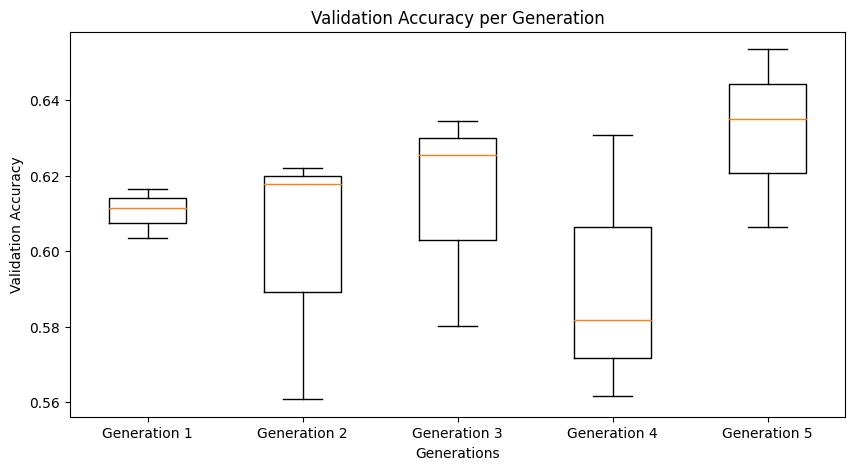

In [108]:
accs
# Graficar len(generations) boxplots con los valores de accs

fig, ax = plt.subplots(figsize=(10, 5))
ax.boxplot(accs)
ax.set_xticklabels([f"Generation {i+1}" for i in range(len(generations))])
ax.set_ylabel("Validation Accuracy")
ax.set_xlabel("Generations")
ax.set_title("Validation Accuracy per Generation")
plt.show()

In [97]:
best_cromosome

[4, 64, 3, 64, 3, 64, 3, 32, 3]

In [104]:
# Entrenar el modelo del mejor cromosoma
train_losses, train_accs, val_losses, val_accs = evaluate_total_cromosome(best_cromosome,
                                                train_data,
                                                val_data,
                                                in_channels = 3,
                                                size = 32,
                                                classes = 10,
                                                epochs = 100,
                                                batch_size = 256,
                                                lr=0.001,
                                                device='cuda',
                                                folder='models')

Best Validation Accuracy: 0.8175
Best Train Accuracy: 0.8729


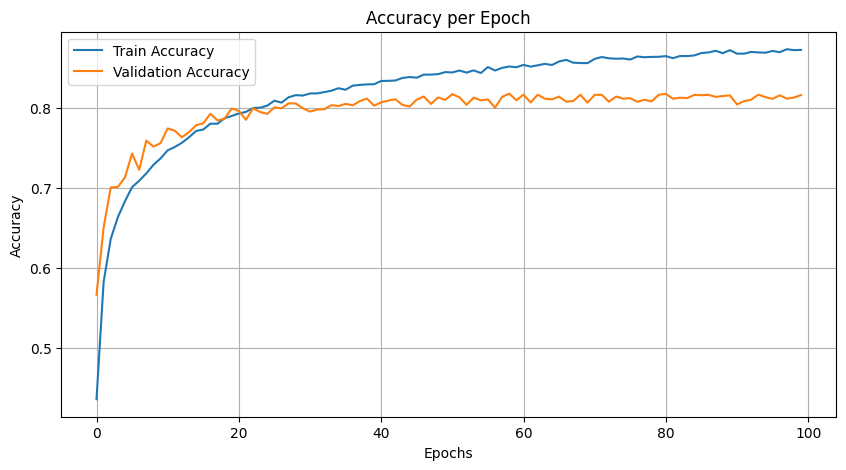

In [112]:
# Curva de entrenamiento y validación (accuracy)
# model = torch.load('models/model.pt') # Modelo que se quiere abrir
# model.eval()
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(train_accs, label="Train Accuracy")
ax.plot(val_accs, label="Validation Accuracy")
ax.set_xlabel("Epochs") 
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy per Epoch")
ax.grid(True, which="both")
ax.legend()
print(f"Best Validation Accuracy: {max(val_accs)}")
print(f"Best Train Accuracy: {max(train_accs)}")